In [47]:
import tensorflow as tf
import keras 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [48]:
path_root = "/content/drive/MyDrive/soil analysis 2222"

from keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(256, 256),batch_size=1818)


Found 1818 images belonging to 4 classes.


In [49]:
batches.class_indices

{'Mary soil': 0, 'chalky': 1, 'sand': 2, 'silt': 3}

In [50]:
imgs, labels = next(batches)

In [51]:
print(imgs.shape)
print(labels.shape)

(1818, 256, 256, 3)
(1818, 4)


In [52]:
# plots images with labels within jupyter notebook
import numpy as np

def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,15):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

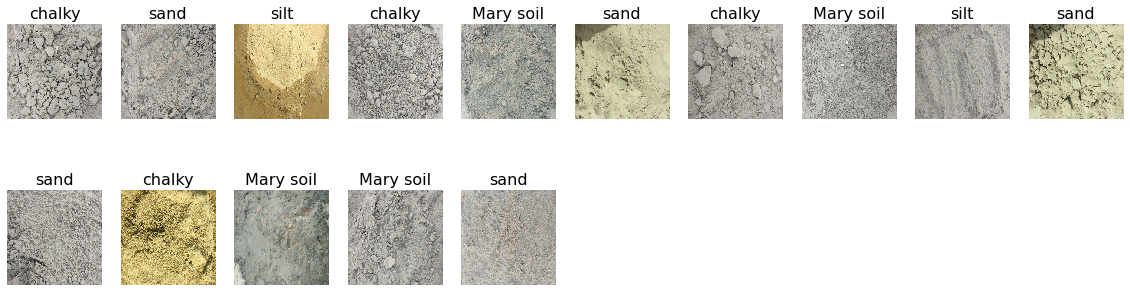

In [53]:
plots(imgs, titles = labels)

<BarContainer object of 4 artists>

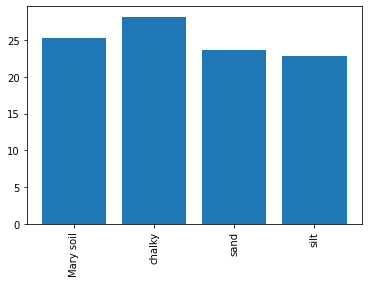

In [55]:
classes = batches.class_indices.keys()
perc = (sum(labels)/labels.shape[0])*100

plt.xticks(rotation='vertical')
plt.bar(classes,perc)

In [56]:
from sklearn.model_selection import train_test_split
# Train, validation and test split

X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.15, random_state=7)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1) 

In [57]:
print("*-*-*-*-*-*")
print("Train")
print(X_train.shape)
print(y_train.shape)


print("*-*-*-*-*-*")
print("Validation")
print(X_val.shape)
print(y_val.shape)

print("*-*-*-*-*-*")
print("Test")
print(X_test.shape)
print(y_test.shape)

*-*-*-*-*-*
Train
(1313, 256, 256, 3)
(1313, 4)
*-*-*-*-*-*
Validation
(232, 256, 256, 3)
(232, 4)
*-*-*-*-*-*
Test
(273, 256, 256, 3)
(273, 4)


In [58]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from keras.applications.resnet import ResNet50

In [59]:
from tensorflow.keras.applications import ResNet50
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256,3))

from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(layers.Dense(4, activation='softmax'))


In [60]:
model.compile(optimizer="rmsprop",
 loss="categorical_crossentropy",
 metrics=["accuracy"])

In [61]:
y_train_new = np.argmax(y_train, axis=1)


In [62]:
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val) ,
                    batch_size = 32, 
                    epochs = 50, 
                   )

Epoch 1/50
42/42 [==============================] - 28s 431ms/step - loss: 5.4450 - accuracy: 0.5491 - val_loss: 3430.4751 - val_accuracy: 0.2069
Epoch 2/50
42/42 [==============================] - 17s 412ms/step - loss: 1.6087 - accuracy: 0.6931 - val_loss: 70.3224 - val_accuracy: 0.2500
Epoch 3/50
42/42 [==============================] - 18s 423ms/step - loss: 1.4070 - accuracy: 0.7182 - val_loss: 74.4500 - val_accuracy: 0.2026
Epoch 4/50
42/42 [==============================] - 18s 431ms/step - loss: 1.0654 - accuracy: 0.7860 - val_loss: 2678.3687 - val_accuracy: 0.3060
Epoch 5/50
42/42 [==============================] - 18s 425ms/step - loss: 0.9056 - accuracy: 0.8233 - val_loss: 120.4402 - val_accuracy: 0.3664
Epoch 6/50
42/42 [==============================] - 18s 421ms/step - loss: 1.1424 - accuracy: 0.8401 - val_loss: 135857.1562 - val_accuracy: 0.2672
Epoch 7/50
42/42 [==============================] - 18s 425ms/step - loss: 0.8616 - accuracy: 0.8553 - val_loss: 769.9601 - val

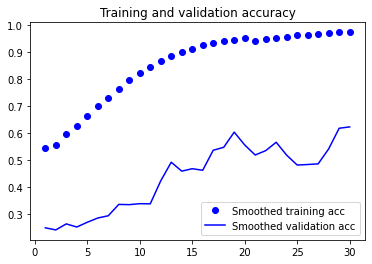

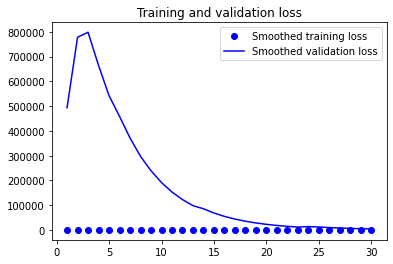

In [63]:
# Smooth Plots

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
     if smoothed_points:
        previous = smoothed_points[-1]
        smoothed_points.append(previous * factor + point * (1 - factor))
     else:
       smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,smooth_curve(accuracy), 'bo', label='Smoothed training acc')
plt.plot(epochs,smooth_curve(val_accuracy), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

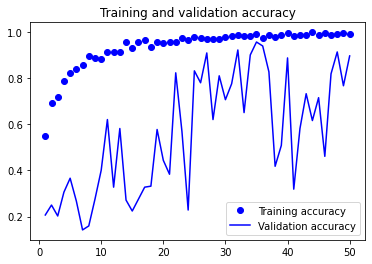

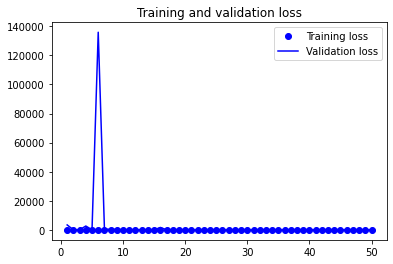

In [64]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

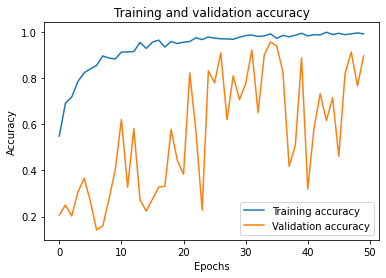

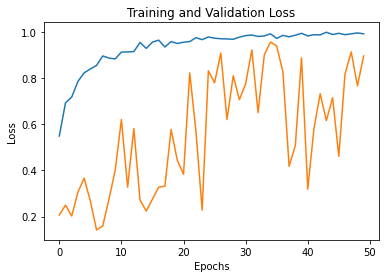

In [65]:

plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Plot using Seaborn

plt.plot(history.history['accuracy'], label="Training loss")
plt.plot(history.history['val_accuracy'], label="Validation loss")
#my_plot = sns.lineplot(data=history[["loss","validation_loss"]])
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend(labels=["Training", "Validation"])
plt.title('Training and Validation Loss')
plt.show()

In [66]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 1s 121ms/step - loss: 1.4438 - accuracy: 0.9267


[1.4437782764434814, 0.9267399311065674]

In [67]:
model.save('soil_analysis.h5')

In [68]:
import numpy as np
import pandas as pd
y_test.shape

(273, 4)

In [69]:
y_pred = model.predict(X_test, verbose=0)
y_pred.shape

(273, 4)

In [70]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

In [73]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

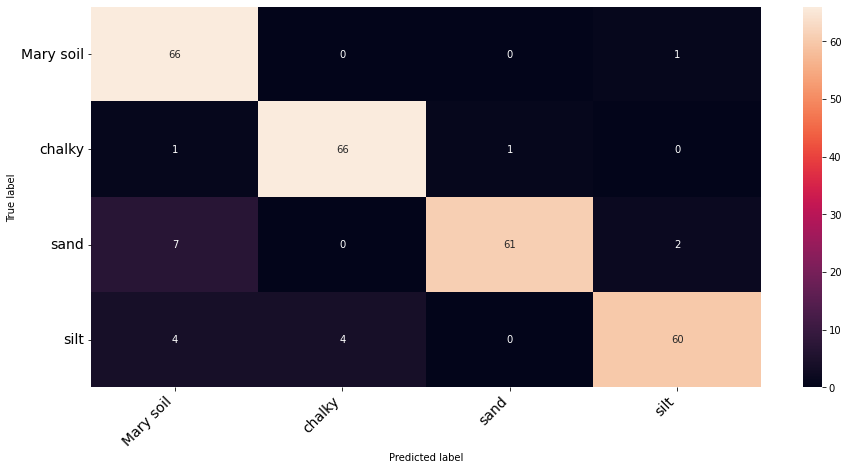

In [74]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (15,7), fontsize=14)

In [75]:
# From categorical outputs to discrete values

y_pred_ = [np.argmax(y) for y in y_pred]
y_test_ = [np.argmax(y) for y in y_test]

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91        67
           1       0.94      0.97      0.96        68
           2       0.98      0.87      0.92        70
           3       0.95      0.88      0.92        68

    accuracy                           0.93       273
   macro avg       0.93      0.93      0.93       273
weighted avg       0.93      0.93      0.93       273



In [77]:
categories = {"Mary soil" : 0,
              "chalky"  : 1,
              "sand"    :2,
              "silt"    :3
              }
              
print(categories)

{'Mary soil': 0, 'chalky': 1, 'sand': 2, 'silt': 3}


In [78]:
def predict_class(img):
    # Resize
    img = img.reshape(1,256,256,3)
    # Predict
    predictions = model.predict(img)
    true_prediction = [tf.argmax(pred) for pred in predictions]
    true_prediction = np.array(true_prediction)
    
    # Return label corresponding to predicted index
    return list(categories.keys())[list(categories.values()).index(true_prediction)]
    

In [79]:
predict_class(X_test[0])

'silt'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

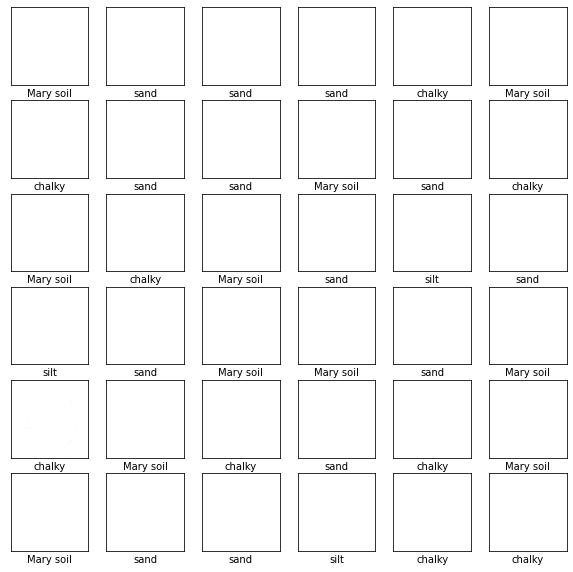

In [80]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(X_test.shape[0],36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(X_test[image_ind]), cmap=plt.cm.binary)
    
    # Predict and get label
    label = predict_class(X_test[image_ind])
    plt.xlabel(label)